In [1]:
%cd ../lib

/spoolA/petrov/research/uproot/lib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from glob import glob
import iminuit
import math

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
jtplot.style(theme='grade3', context='paper', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

In [76]:
from scipy.integrate import quad
class MDVM():
    def __init__(self):
        self.ALPHA = 7.297352e-3
        self.C = 0.3893793656e12 #(MeV)^2 * nb

        self.mPhi = 1019.464
        self.mRho = 775.26
        self.mOmg = 782.65

        self.mK0 = 497.611
        self.mP0 = 135.
        self.mKC = 493.677
        self.mPC = 139.57
        self.mKstar = 891.76

        self.w0Phi = 4.247
        self.w0Rho = 149.1
        self.w0Omg = 8.49
    
    def BETA(self, s, M_K): #бета
        E = np.sqrt(s)/2.
        P = np.where( E<M_K, 0, np.sqrt( E**2 - M_K**2 ) )
        return P/E
    def q(self, M, m1, m2):
        return math.sqrt( (M**2 - (m1 - m2)**2 )*( M**2 - (m1 + m2)**2 ) )/(2*M)
    def PV2_diff(self, s, M, mi, mj): #фазовый объём распада на 2 разные частицы https://arxiv.org/pdf/hep-ph/9609216.pdf (2.6)
        q0 = np.sqrt( (M**2 - (mi - mj)**2)*(M**2 - (mi + mj)**2) )/(2*M)
        E = np.sqrt(s)
        q_temp = np.where( E <= (mi + mj), 0, (E**2 - (mi - mj)**2)*(E**2 - (mi + mj)**2) )
        q1 = np.sqrt( q_temp )/(2*E)
        return (q1/q0)**3
    def PV2(self, s, M, Mn): #фазовый объём распада на 2 одинаковые частицы
        w = np.where(s <= 4*Mn*Mn, 0, np.power( (s - 4*Mn**2)/(M**2 - 4*Mn**2), 3./2 )*(M**2)/s )
        return w
#     def FAS3(self, s):
#         twoe = (np.sqrt(np.array(s))*1e-3).reshape((-1,1)) #GeV        
#         A = np.array([-6.12394622, 25.0341405, -34.1311022, 15.5413717])
#         B = np.array([5.29354148, -7.90990714, -2.26007613, 5.21453902])
#         LM = 1.1
#         E = np.array([twoe**i for i in range(A.shape[0])])
#         POL = (np.where(twoe >= LM, B, A)*E).sum(axis=(0,2))
#         Fval = (POL/0.393728*(0.00749/0.0361478))
#         return Fval
    def FAS3_RhoPiPi(self, s):
        e = np.sqrt(s)*1e-3
        f1 = 1.9e-3 + 2.68e-2*(e-1.2) + 2.446e-1 * (e-1.2)**2 + 3.1487 * (e-1.2)**3 + 23.3131 * (e-1.2)**4 + 59.7669 * (e-1.2)**5
        f2 = 1.9e-3 + 2.33e-2*(e-1.2) + 6.65e-2 * (e-1.2)**2 - 3.84e-2 * (e-1.2)**3 + 2.36e-2 * (e-1.2)**4 - 6.5e-3 * (e-1.2)**5
        return np.where(e<1.2, f1, f2)
    def FAS3_OmgPiPi(self, s):
        e = np.sqrt(s)*1e-3
        f1 = 1.7e-3 + 2.61e-2*(e-1.2) + 2.67e-1 * (e-1.2)**2 + 3.61199 * (e-1.2)**3 + 27.6 * (e-1.2)**4 + 73.6433 * (e-1.2)**5
        f2 = 1.7e-3 + 2.18e-2*(e-1.2) + 6.89e-2 * (e-1.2)**2 - 4.52e-2 * (e-1.2)**3 + 3.25e-2 * (e-1.2)**4 - 1.09e-2 * (e-1.2)**5
        return np.where(e<1.2, f1, f2)
    def FAS3(self, s):
        e = np.sqrt(s)*1e-3
        f1 = 5.196 + 59.17*(e-1) + 227.7 * (e-1)**2 + 147 * (e-1)**3 - 998 * (e-1)**4 - 1712 * (e-1)**5
        f2 = 5.196 + 80*(e-1) + 200 * (e-1)**2 + 590 * (e-1)**3 - 510 * (e-1)**4 + 220 * (e-1)**5
        return np.where(e<1, f1, f2)
    def PV3(self, s, MX, m1, m2, m3): #фазовый объём (почти: он типа нормирован) распада на 3 частицы
        #WARNING. TRY TO FIND THE RIGHT VARIANT
        pv = self.FAS3(s)
        pv0 = self.FAS3(MX**2)
        return pv/pv0
    def PVG(self, s, MX, Mn): #распад частицы M на фотон и частицу Mn
        pv  = ((s - Mn**2)/(2*np.sqrt(s)))**3
        pv0 = ((MX**2 - Mn**2)/(2*MX))**3
        return np.where(pv>0, pv/pv0, 0)
#     def WVPpi_f(self, s, mV, mP, m):
#         if math.sqrt(s)<=(mV+mP+self.mP0):
#             return 0
#         q = self.q
#         return ( 1 + ( q(math.sqrt(s), mV, m)**2 )/(3*(mV**2)) )*q(math.sqrt(s), mV, m)*q(m, mP, self.mP0)/(4*s*(2*math.pi)**3)
#     def WVPpi(self, s, mV, mP):
#         return np.array([quad(lambda m: self.WVPpi_f(s0, mV, mP, m), mP+self.mP0, math.sqrt(s0) - mV, epsrel=0.01)[0] for s0 in s])
#     def PVPpi(self, s, mV, mP, MX):
#         pv = self.WVPpi(s, mV, mP)
#         pv0 = self.WVPpi([MX**2], mV, mP)
#         return pv/pv0
    def P_RhoPiPi(self, s, MX):
        return np.where( np.sqrt(s)>self.mRho+2*self.mP0, self.FAS3_RhoPiPi(s)/self.FAS3_RhoPiPi(MX**2), 0 )
    def P_OmgPiPi(self, s, MX):
        return np.where( np.sqrt(s)>self.mOmg+2*self.mP0, self.FAS3_OmgPiPi(s)/self.FAS3_OmgPiPi(MX**2), 0 )
    
    def WRho(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mPC)
    def WOmg(self, s, W0, MX):    
        Br_3Pi = 0.892    
        Br_Pi0G = 0.084
        Br_2Pi = 0.0153
        ost = 1 - Br_Pi0G - Br_2Pi - Br_3Pi;
        
        mPC = self.mPC
        mP0 = self.mP0

        W = W0 * ((Br_3Pi + ost) * self.PV3(s, MX, mPC, mPC, mP0) + \
                  Br_Pi0G * self.PVG(s, MX, mP0) + Br_2Pi * self.PV2(s, MX, mPC));
        return W
    def WPhi(self, s, W0, MX):
        Br_KC = 0.492
        Br_KN = 0.34
        Br_3Pi = 0.1524
        Br_EG = 0.01303
        ost = 1 - Br_KC - Br_KN - Br_3Pi - Br_EG

        mEta = 547.862
        mKC = self.mKC
        mK0 = self.mK0
        mPC = self.mPC
        mP0 = self.mP0

        W = W0*((Br_KC + ost)* self.PV2(s, MX, mKC) + Br_KN* self.PV2(s, MX, mK0) + \
                Br_3Pi * self.PV3(s, MX, mPC, mPC, mP0) + Br_EG * self.PVG(s, MX, mEta));
        return W
    def WPhi1680(self, s, W0, MX): #fully KK* decay
        W = W0*self.PV2_diff(s, MX, self.mKC, self.mKstar)
        return W
    def WRho1(self, s, W0, MX): #\omega \pi
        return W0 * self.PV2_diff(s, MX, self.mP0, self.mOmg)
    def WRhoN(self, s, W0, MX): #\rho \pi \pi
        return W0 * self.P_RhoPiPi(s, MX)
    def WOmg1(self, s, W0, MX): #\rho \pi
        return W0 * self.PV2_diff(s, MX, self.mP0, self.mRho)
    def WOmgN(self, s, W0, MX): #\omega \pi \pi
        return W0 * self.P_OmgPiPi(s, MX)
    
    def WRhoX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mPC)
    def WOmgX(self, s, W0, MX):
        return W0 * self.PV2_diff(s, MX, self.mRho, self.mP0) #self.PV3(s, MX, self.mPC, self.mPC, self.mP0)
    def WPhiX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mKC)
    
    def BW(self, s, MX, WX0, WX): #функция Брейта-Вигнера
        bw = (MX**2)/( MX**2 - s - 1j*MX*WX(s, WX0, MX) )#np.sqrt(s)
        return bw
    def BW_RhoX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WRhoX)
    def BW_OmgX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WOmgX)
    def BW_PhiX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WPhiX)
    
    def BW_Rho(self, s):
        return self.BW(s, self.mRho, self.w0Rho, self.WRho)
    def BW_Omg(self, s):
        return self.BW(s, self.mOmg, self.w0Omg, self.WOmg)
    def BW_Phi(self, s):
        return self.BW(s, self.mPhi, self.w0Phi, self.WPhi)
    def BW_Rho1(self, s, m=1465, g=400):
        return self.BW(s, m, g, self.WRho1)#self.BW_RhoX(s, m, g)
    def BW_Rho3(self, s, m=1720, g=250):
        return self.BW(s, m, g, self.WRhoN)#self.BW_RhoX(s, m, g)
    def BW_Omg1(self, s, m=1420, g=220):
        return self.BW(s, m, g, self.WOmg1)#self.BW_OmgX(s, m, g)
    def BW_Omg2(self, s, m=1670, g=315):
        return self.BW(s, m, g, self.WOmgN)#self.BW_OmgX(s, m, g)
    def BW_Phi1(self, s, m=1673, g=182):
        return self.BW(s, m, g, self.WPhi1680)
    def BW_Phi2(self, s, m=2198, g=71):
        return self.BW(s, m, g, self.WPhi1680)#self.BW_PhiX(s, mPhi2, gPhi2)#BESIII:2239.2, 139.8 #PDG: 2198, 71 
    
    #PUBLIC
    def F0(self, x, KR, KO, KP, n): #формфактор, нулевое приближение; mode: 0 - short/long; 1 - charged;
        s = (x*1e3)**2 
        F = KR * self.BW_Rho(s) + KO * self.BW_Omg(s) + n * KP * self.BW_Phi(s)
        return F
    def F1(self, x, par, charged=False): #формфактор с учётом omega(1400)
        n = 1 if charged else par[0] #1.027
        s = (x*1e3)**2
        CR = np.array([par[1], par[2], par[3], 0])
        CR[-1] = 1 - CR.sum()
        CO = np.array([par[20], par[21], par[22], par[23]])
        CP = np.array([par[4], par[5], 0])
        CP[-1] = 3/2. - CO.sum()/2 - CP.sum()
#         print(CR, CO, CP)
        KR = CR/2. if charged else -CR/2.
        KO = CO/6.
        KP = CP/3.
        
        F1 = self.F0(x, KR[0], KO[0], KP[0], n)
        m3, w3 = par[6], par[7] #2150, 350
        m4, w4 = par[8], par[9]
        m5, w5 = par[10], par[11]
        m6, w6 = par[12], par[13]
        m1, w1 = par[14], par[15]
        m2, w2 = par[16], par[17]        
        m7, w7 = par[18], par[19]
        F1 += KR[1] * self.BW_Rho1(s, m1, w1) + KR[2] * self.BW_Rho3(s, m3, w3) + KR[3] * self.BW_Rho3(s, m6, w6)
        F1 += KO[1] * self.BW_Omg1(s, m2, w2) + KO[2] * self.BW_Omg2(s, m4, w4) + KO[3] * self.BW_Omg2(s, m6, w6) 
        F1 += KP[1] * self.BW_Phi1(s, m5, w5) + KP[2] * self.BW_Phi2(s, m7, w7)
        return F1
        
    def Cross_Section(self, x, par, charged=False):
        s = (x*1e3)**2
        fabs2 = np.abs( self.F1(x, par, charged) )**2
        M_K = self.mKC if charged else self.mK0
        constant = (np.pi/3.) * (self.ALPHA**2) * self.C
        cs = np.where( x<0.4976*2, 0, constant * (self.BETA(s, M_K)**3) * fabs2 / s  )
        return cs
    def Cross_Section_Neutral(self, x, par):
        return self.Cross_Section(x, par, False)
    def Cross_Section_Charged(self, x, par):
        return self.Cross_Section(x, par, True)    
    def Cross_Section2Formfacror(self, x, cs, mode=False):
        s = (x*1e3)**2
        M_K = self.mKC if mode else self.mK0
        constant = (np.pi/3.) * (self.ALPHA**2) * self.C
        return cs*s/(constant * ( self.BETA(s, M_K)**3 ) )

In [4]:
%load_ext autoreload
%autoreload 2
import lib

In [5]:
#neutral kaons
cs_n = [lib.get_KSKL_phi(), lib.get_KSKL_babar(), 
        lib.get_KSKL_up('./data/fit_frame_19_2205.csv', './data/rad_frame_19.csv'),
        lib.get_KSKL_up('./data/fit_frame_17_2205.csv', './data/rad_frame_17.csv'),
        lib.get_KSKL_up('./data/fit_frame_12_2205.csv', './data/rad_frame_12.csv'),
        lib.get_KSKL_up('./data/fit_frame_11_2205.csv', './data/rad_frame_11.csv'),
#         lib.get_KSKL_up('./data/fit_frame_13_rotated.csv', './data/rad_frame_v6_rotated2.csv'),
       ] 
#charged kaons
cs_c = [lib.get_KPKM_phi(), lib.get_KPKM_up2(), lib.get_KPKM_up()]

In [77]:
A = MDVM()

In [65]:
max_e = 1.8
min_e = 0.4
def least_squares(par):
    chisq = 0
    p = par
    for c in np.array(cs_n)[[0,2,3,4,5]]: #0,2,3,4,5
        chisq += np.square( (c.cs - A.Cross_Section_Neutral(c.energy, par))/c.cs_err )[(c.energy<max_e)&(c.energy>min_e)].sum()
    for c in cs_c:
        chisq += np.square( (c.cs - A.Cross_Section_Charged(c.energy, par))/c.cs_err )[(c.energy<max_e)&(c.energy>min_e)].sum()
    return chisq

In [66]:
least_squares(params)

6711.409509742147

In [78]:
names = [ '\\eta', '$\\rho$', '$\\omega$', '$\\phi$', '$\\rho\'$', '$\\omega\'$', '$\\phi\'$', 
         '$\\rho\'\'$', '$\\omega\'\'$']
params = [0.9639, 1.0919, -0.0062, -0.0279, 1.0509, -0.0674, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 225.0, 2239.0, 139.0, 1.3856, 0.0064, -0.2363, 0.01]
fix_pars = [False, False, False, False, 
            False, False,
            True, True, True, True, True, True, True, True,
            True, True, True, True, True, True,
            False, False, False, False] # True False
error_pars = 0.01*np.array(params)

In [82]:
limits = [
    (None, None), (None, None),(None, None),(None, None),(None, None),(None, None),
    (1720-20, 1720+20), (250-100, 250+100), (1670-30, 1670+30), (315-35, 315+35), (1660, 1700), (100, 200), 
    (1990, 2250), (100, 400),(1440,1490),(340,460),(1400,1450),(180,250),
    (2239-10, 2239+10),(139-12, 139+12),(None, None),(None, None),(None, None),(None, None)
]

In [83]:
# from scipy.optimize import minimize
# result = minimize(least_squares, np.array(params))
# result

In [84]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, \
                                   error=error_pars, errordef=1, limit=limits)#, name=names, 
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.964   |   0.010   |            |            |         |         |       |
| 1 | x1   |   1.092   |   0.011   |            |            |         |         |       |
| 2 | x2   | -0.620E-2 | -0.006E-2 |            |            |         |         |       |
| 3 | x3   | -2.790E-2 | -0.028E-2 |            |            |         |         |       |
| 4 | x4   |   1.051   |   0.011   |            |            |         |         |       |
| 5 | x5   | -0.674E-1 | -0.007E-1 |            |            |         |         |       |
| 6 | x6   |   1740    |    17     |            |            |  1700   |  1740   |  yes  |
| 7 | x7   |   250.0   |    2.5    |            |            |   150   |   350   |  yes  |
| 8 | x8   |   1670    |    17     |            |            |  1640   |  1700   |  yes  |
| 9 | x9   |   315.0   |    3.1    |            |            |   280   |   350   |  yes  |
| 10| x10  |   1680    |    17     |            |            |  1660   |  1700   |  yes  |
| 11| x11  |   150.0   |    1.5    |            |            |   100   |   200   |  yes  |
| 12| x12  |   2150    |    22     |            |            |  1990   |  2250   |  yes  |
| 13| x13  |   315.0   |    3.1    |            |            |   100   |   400   |  yes  |
| 14| x14  |   1470    |    15     |            |            |  1440   |  1490   |  yes  |
| 15| x15  |    400    |     4     |            |            |   340   |   460   |  yes  |
| 16| x16  |   1425    |    14     |            |            |  1400   |  1450   |  yes  |
| 17| x17  |   225.0   |    2.2    |            |            |   180   |   250   |  yes  |
| 18| x18  |   2239    |    22     |            |            |  2229   |  2249   |  yes  |
| 19| x19  |   139.0   |    1.4    |            |            |   127   |   151   |  yes  |
| 20| x20  |   1.386   |   0.014   |            |            |         |         |       |
| 21| x21  | 0.640E-2  | 0.006E-2  |            |            |         |         |       |
| 22| x22  | -2.363E-1 | -0.024E-1 |            |            |         |         |       |
| 23| x23  | 1.000E-2  | 0.010E-2  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [87]:
m.migrad()

RuntimeError: exception was raised in user function
User function arguments:
     x0 = +0.986212
     x1 = +1.140535
     x2 = -0.069581
     x3 = -0.022855
     x4 = +1.033524
     x5 = -0.097736
     x6 = +1740.000000
     x7 = +250.000000
     x8 = +1670.000000
     x9 = +315.000000
    x10 = +1680.000000
    x11 = +150.000000
    x12 = +2150.000000
    x13 = +315.000000
    x14 = +1470.000000
    x15 = +400.000000
    x16 = +1425.000000
    x17 = +225.000000
    x18 = +2239.000000
    x19 = +139.000000
    x20 = +1.567777
    x21 = -0.066104
    x22 = -0.177177
    x23 = +0.915050
Original python exception in user function:
KeyboardInterrupt: 
  File "<ipython-input-65-503b15baa9df>", line 9, in least_squares
    chisq += np.square( (c.cs - A.Cross_Section_Charged(c.energy, par))/c.cs_err )[(c.energy<max_e)&(c.energy>min_e)].sum()
  File "<ipython-input-76-e059281190b9>", line 204, in Cross_Section_Charged
    return self.Cross_Section(x, par, True)
  File "<ipython-input-76-e059281190b9>", line 196, in Cross_Section
    fabs2 = np.abs( self.F1(x, par, charged) )**2
  File "<ipython-input-76-e059281190b9>", line 181, in F1
    F1 = self.F0(x, KR[0], KO[0], KP[0], n)
  File "<ipython-input-76-e059281190b9>", line 166, in F0
    F = KR * self.BW_Rho(s) + KO * self.BW_Omg(s) + n * KP * self.BW_Phi(s)
  File "<ipython-input-76-e059281190b9>", line 149, in BW_Phi
    return self.BW(s, self.mPhi, self.w0Phi, self.WPhi)
  File "<ipython-input-76-e059281190b9>", line 135, in BW
    bw = (MX**2)/( MX**2 - s - 1j*MX*WX(s, WX0, MX) )#np.sqrt(s)
  File "<ipython-input-76-e059281190b9>", line 113, in WPhi
    Br_3Pi * self.PV3(s, MX, mPC, mPC, mP0) + Br_EG * self.PVG(s, MX, mEta));
  File "<ipython-input-76-e059281190b9>", line 62, in PV3
    pv = self.FAS3(s)
  File "<ipython-input-76-e059281190b9>", line 58, in FAS3
    f2 = 5.196 + 80*(e-1) + 200 * (e-1)**2 + 590 * (e-1)**3 - 510 * (e-1)**4 + 220 * (e-1)**5
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/ops/common.py", line 64, in new_method
    return method(self, other)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py", line 503, in wrapper
    result = arithmetic_op(lvalues, rvalues, op, str_rep)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py", line 197, in arithmetic_op
    res_values = na_arithmetic_op(lvalues, rvalues, op, str_rep)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py", line 149, in na_arithmetic_op
    result = expressions.evaluate(op, str_rep, left, right)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py", line 208, in evaluate
    return _evaluate(op, op_str, a, b)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py", line 102, in _evaluate_numexpr
    if _can_use_numexpr(op, op_str, a, b, "evaluate"):
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py", line 78, in _can_use_numexpr
    if np.prod(a.shape) > _MIN_ELEMENTS:
  File "<__array_function__ internals>", line 6, in prod
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 2962, in prod
    keepdims=keepdims, initial=initial, where=where)
  File "/store17/petrov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 74, in _wrapreduction
    passkwargs = {k: v for k, v in kwargs.items()


In [88]:
params = m.np_values()
print('params =', list(m.np_values().round(4)) )

params = [0.9862, 1.1406, -0.0696, -0.0229, 1.0335, -0.0977, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 225.0, 2239.0, 139.0, 1.5678, -0.0661, -0.1772, 0.915]


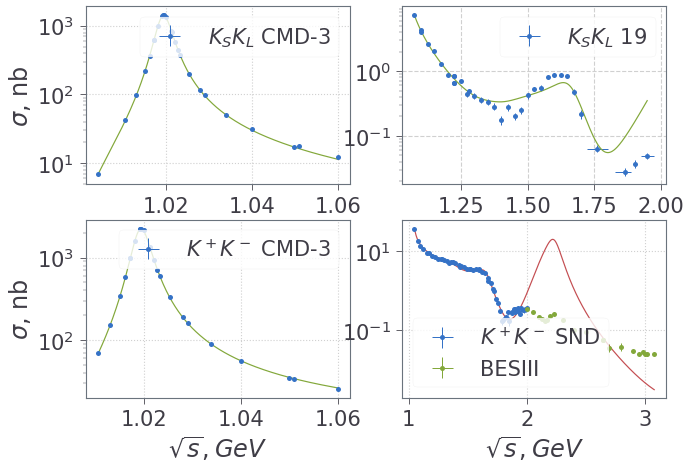

In [89]:
plt.subplot(221)
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[0]], ['$K_SK_L$ CMD-3'])
my_style('','', '$\sigma$, nb')

plt.subplot(222)
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[2]], ['$K_SK_L$ 19'])

plt.subplot(223)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[0]], ['$K^+K^-$ CMD-3'])
my_style('','$\sqrt{s}, GeV$', '$\sigma$, nb')

plt.subplot(224)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[2], cs_c[1]], ['$K^+K^-$ SND', 'BESIII'])
my_style('','$\sqrt{s}, GeV$', '')
# plt.savefig('../Journal/outputs/images/sec_fit.png', dpi=200)

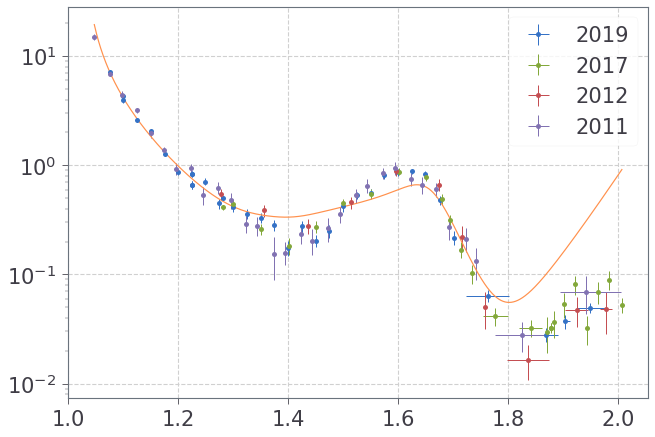

In [90]:
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[2], cs_n[3], cs_n[4], cs_n[5]],
            ['2019','2017', '2012', '2011'])# '2013'])

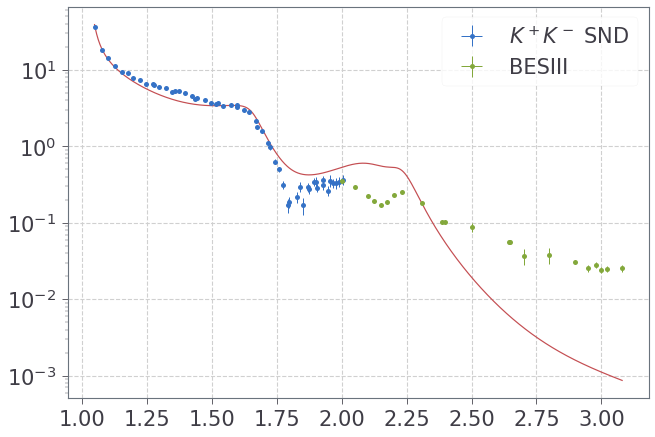

In [75]:
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[2], cs_c[1]], ['$K^+K^-$ SND', 'BESIII'])

In [900]:
def q(M, m1, m2):
    return math.sqrt( (M**2 - (m1 - m2)**2 )*( M**2 - (m1 + m2)**2 ) )/(2*M)
def D(s, M, W0, W):
    Re = M**2 - s
    Im = 0
    if W(s, W0, M)>0:
        Im = - 1j*math.sqrt(s)*W(s, W0, M)
    return (Re+Im)

In [413]:
def W3pi(s, m, x):
    e = math.sqrt(s)
    mPi = 135
    mRho = 775.26
    w0Rho = 149.1
    q_rho, q_pi = q(e, m, mPi), q(m, mPi, mPi)
    q_rho3 = q_rho**3
    q_pi3 = q_pi**3
    m_p2 = (s + 3*(mPi**2) - m**2)/2 + (2*s/m)*q_pi*q_rho*x
    m_m2 = (s + 3*(mPi**2) - m**2)/2 - (2*s/m)*q_pi*q_rho*x
    D1 = D(m**2, mRho, w0Rho, A.WRhoX)
    D2 = D(m_m2, mRho, w0Rho, A.WRhoX)
    D3 = D(m_p2, mRho, w0Rho, A.WRhoX)
    return q_rho3*q_pi3*(1-x**2)*(np.abs(1/D1 + 1/D2 + 1/D3))**2

In [220]:
from scipy.integrate import dblquad
def W(s):
    return dblquad(lambda x, m: W3pi(s, m, x), 2*135, math.sqrt(s)-135, lambda x: -1, lambda x: 1, epsrel=0.01)

In [222]:
e = np.linspace(700, 2000, 50)

In [223]:
Ws = [W(e0**2)[0] for e0 in e]

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


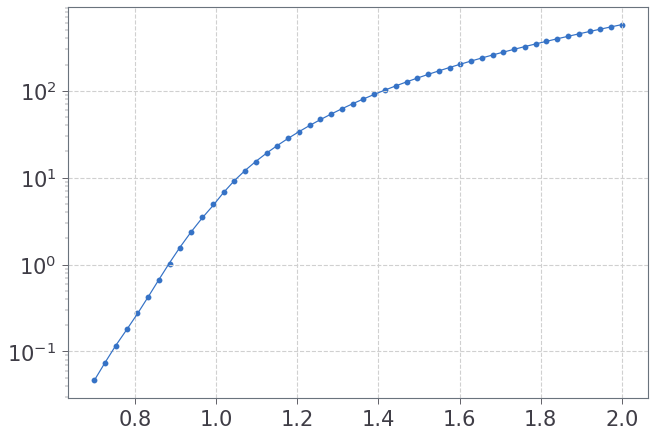

In [381]:
plt.scatter(np.array(e)*1e-3, np.array(Ws)*1e-6)
plt.plot(np.array(e)*1e-3, y0(pars))
plt.yscale('log')

In [240]:
np.array([1,2])**np.array([1,2])

array([1, 4])

In [367]:
n0 = 11
def f(par):
    par1, par2 = par[1:6], par[6:]
    et = np.array(e)*1e-3
    e0 = (np.array(e)*1e-3 - 1.).reshape((-1,1))**np.arange(1, 6)
    y = np.where(et<1., np.sum(par1*e0, axis=1), np.sum(par2*e0, axis=1) ) + par[0]
    return np.sum( ((np.array(Ws)*1e-6 - y)/(0.1*y))**2 )
def y0(par):
#     e0 = (np.array(e)*1e-3).reshape((-1,1))**np.arange(n0)
#     y = np.sum(par*e0, axis=1)
    par1, par2 = par[1:6], par[6:]
    et = np.array(e)*1e-3
    e0 = (np.array(e)*1e-3 - 1.).reshape((-1,1))**np.arange(1, 6)
    y = np.where(et<1., np.sum(par1*e0, axis=1), np.sum(par2*e0, axis=1) ) + par[0]
    return y
pars = np.ones(n0)

In [379]:
m = iminuit.Minuit.from_array_func(f, pars, pedantic=False)

In [380]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.7998                  |     Ncalls=177 (177 total)     |
| EDM = 4.55E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   5.196   |   0.027   |            |            |         |         |       |
| 1 | x1   |   59.17   |   0.14    |            |            |         |         |       |
| 2 | x2   |   227.7   |    0.5    |            |            |         |         |       |
| 3 | x3   |   147.0   |    1.7    |            |            |         |         |       |
| 4 | x4   |   -998    |     5     |            |            |         |         |       |
| 5 | x5   |   -1712   |     16    |            |            |         |         |       |
| 6 | x6   |    80     |    10     |            |            |         |         |       |
| 7 | x7   |    200    |    70     |            |            |         |         |       |
| 8 | x8   |    590    |    140    |            |            |         |         |       |
| 9 | x9   |   -510    |    190    |            |            |         |         |       |
| 10| x10  |    220    |    150    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [206]:
W3pi(1100**2, 390, 0.1)

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


1423.0496658637828

In [492]:
from scipy.integrate import quad
def WVPpi_f(s, mV, mP, m):
    return ( 1 + ( q(math.sqrt(s), mV, m)**2 )/(3*(mV**2)) )*q(math.sqrt(s), mV, m)*q(m, mP, A.mP0)/(4*s*(2*math.pi)**3)
def WVPpi(s, mV, mP):
    res = np.array([quad(lambda m: WVPpi_f(s0, mV, mP, m), mP+A.mP0, math.sqrt(s0) - mV, epsrel=0.01)[0] for s0 in s])
    return res

In [697]:
e0 = np.linspace( (A.mOmg+ 2*A.mP0)*1e-3, 2, 50)
# w = [ WVPpi((e*1e3)**2, A.mRho, A.mP0) for e in e0]

In [698]:
w = WVPpi((e0*1e3)**2, A.mOmg, A.mP0)

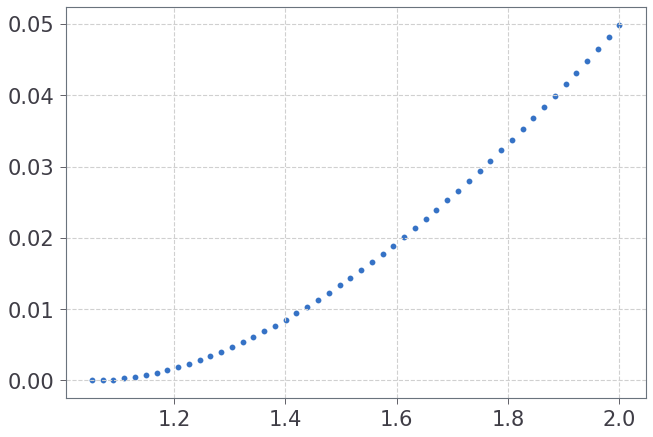

In [699]:
plt.scatter(e0, w)

In [700]:
n0 = 11
th = 1.2
def f(par):
    par1, par2 = par[1:6], par[6:]
    ee = (e0 - th).reshape((-1,1))**np.arange(1, 6)
    y = np.where(e0<th, np.sum(par1*ee, axis=1), np.sum(par2*ee, axis=1) ) + par[0]
    return np.sum( ((w - y)/(0.001+0.1*w))**2 )
def y0(par):
    par1, par2 = par[1:6], par[6:]
    ee = (e0 - th).reshape((-1,1))**np.arange(1, 6)
    y = np.where(e0<th, np.sum(par1*ee, axis=1), np.sum(par2*ee, axis=1) ) + par[0]
    return y
pars = np.ones(n0)

In [701]:
m = iminuit.Minuit.from_array_func(f, pars, pedantic=False)

In [702]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.0004909               |     Ncalls=583 (583 total)     |
| EDM = 1.1E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  1.7E-3   |  0.6E-3   |            |            |         |         |       |
| 1 | x1   |   0.026   |   0.025   |            |            |         |         |       |
| 2 | x2   |   0.27    |   0.34    |            |            |         |         |       |
| 3 | x3   |    3.6    |    2.8    |            |            |         |         |       |
| 4 | x4   |    28     |    20     |            |            |         |         |       |
| 5 | x5   |    70     |    110    |            |            |         |         |       |
| 6 | x6   |   0.022   |   0.007   |            |            |         |         |       |
| 7 | x7   |   0.069   |   0.024   |            |            |         |         |       |
| 8 | x8   |   -0.05   |    0.04   |            |            |         |         |       |
| 9 | x9   |   0.03    |   0.06    |            |            |         |         |       |
| 10| x10  |  -0.011   |   0.063   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [703]:
pars = m.np_values()

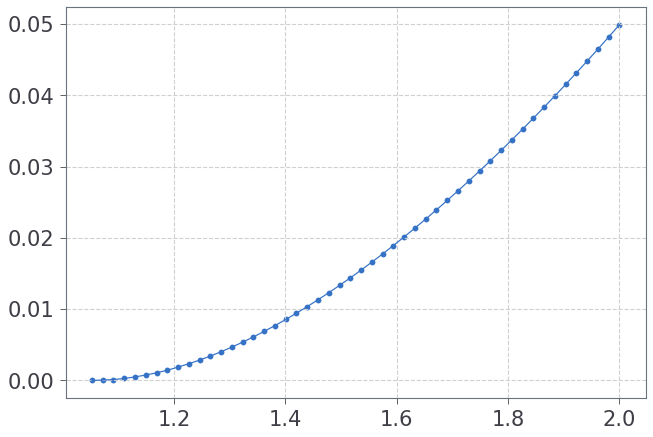

In [704]:
plt.scatter(e0, w)
plt.plot(np.array(e0), y0(pars))
# plt.yscale('log')

In [705]:
m.np_values()

array([ 1.70211406e-03,  2.60927731e-02,  2.67020132e-01,  3.61198920e+00,
        2.76023868e+01,  7.36433471e+01,  2.18223373e-02,  6.89263647e-02,
       -4.51554766e-02,  3.25452049e-02, -1.09294067e-02])

In [710]:
    def FAS3_OmgPiPi(s):
        e = np.sqrt(s)*1e-3
        f1 = 1.7e-3 + 2.61e-2*(e-1.2) + 2.67e-1 * (e-1.2)**2 + 3.61199 * (e-1.2)**3 + 27.6 * (e-1.2)**4 + 73.6433 * (e-1.2)**5
        f2 = 1.7e-3 + 2.18e-2*(e-1.2) + 6.89e-2 * (e-1.2)**2 - 4.52e-2 * (e-1.2)**3 + 3.25e-2 * (e-1.2)**4 - 1.09e-2 * (e-1.2)**5
        return np.where(e<1.2, f1, f2)

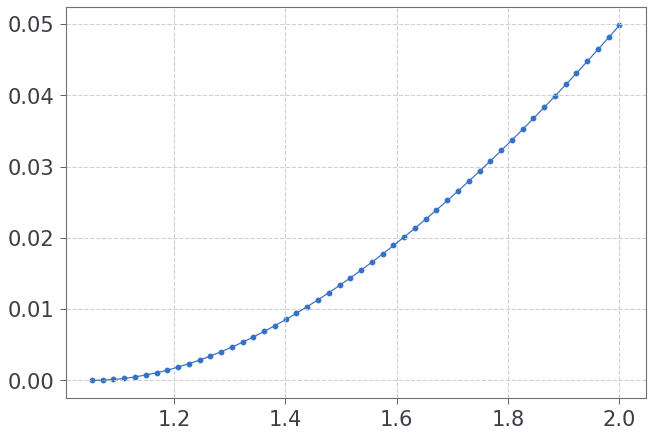

In [711]:
plt.scatter(e0, w)
plt.plot( e0, FAS3_OmgPiPi((e0*1e3)**2) )
# plt.yscale('log')